In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import linregress
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
from skimage.color import rgb2gray
from skimage.draw import disk
from matplotlib.patches import Circle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from pathlib import Path
import re

# Functions

In [ ]:
def scatter_plot(df, x_col, y_col, 
                 x_lim=None, 
                 y_lim=None):

    plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(df[x_col], df[y_col], alpha=0.6)

    plt.xlabel(x_col.replace("_", " "))
    plt.ylabel(y_col.replace("_", " "))

    # Fixed scale
    if x_lim is not None:
        plt.xlim(x_lim)

    if y_lim is not None:
        plt.ylim(y_lim)

    plt.tight_layout()
    plt.show()



def plot_histogram(df, column, bins=50, xlabel=None, title=None,
                   figsize=(4, 3), dpi=300):

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.hist(
        df[column].dropna(),
        bins=bins,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8
    )

    ax.set_xlabel(xlabel if xlabel else column, fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.set_title(title if title else f"Distribution of {column}", fontsize=12)

    # Clean style
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


def plot_foci_on_image(
    gray_image,
    df,
    x_col="x_px",
    y_col="y_px",
    r_col="sigma_px",
    circle_color="red",
    center_size=6,
    linewidth=1,
    figsize=(7, 7),
    show=True
):
    """
    Plot detected foci as circles on a grayscale image.

    Parameters
    ----------
    gray_image : 2D numpy array
        Grayscale image.
    df : pandas DataFrame
        DataFrame containing coordinates and radii.
    x_col, y_col : str
        Column names for x and y coordinates.
    r_col : str
        Column name for radius (in pixels).
    circle_color : str
        Color of circle and center dot.
    center_size : int
        Size of center dot.
    linewidth : int
        Circle outline thickness.
    figsize : tuple
        Figure size.
    show : bool
        Whether to call plt.show().
    """

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(gray_image, cmap="gray")

    for x_px, y_px, r_px in zip(df[x_col], df[y_col], df[r_col]):
        # circle outline
        ax.add_patch(
            Circle(
                (x_px, y_px),
                r_px,
                fill=False,
                edgecolor=circle_color,
                linewidth=linewidth
            )
        )
        # center dot
        ax.scatter(x_px, y_px, c=circle_color, s=center_size)

    ax.axis("off")

    if show:
        plt.show()

    return fig, ax



In [15]:
df = pd.read_csv("./examples/run/C2_MP_U2OS_fixed_20nMJF549_ORC1_MGS1.nd2_(series_01)_extent.csv")

In [16]:
df

,id,x [nm],y [nm],sigma [nm],intensity [photon],uncertainty_xy [nm],x_px,y_px,sigma_px,mean_intensity,Outlier
0,3,5664.00179,8115.08397,105.36936,6466.30563,8.95652,99,138,2,0.122440,False
1,4,5740.10787,6716.86459,77.62390,2201.61762,14.41114,100,114,1,0.039216,False
2,6,5666.67952,6795.26104,106.65626,3993.26498,14.19983,99,116,2,0.097168,False
3,7,5652.78010,7987.84670,76.57273,3171.86061,9.49600,98,136,1,0.137255,False
4,12,5914.34292,8837.20511,177.81491,10287.93656,12.52094,103,151,3,0.121255,False
...,...,...,...,...,...,...,...,...,...,...,...
712,1086,23856.05906,17601.05382,107.93776,2470.76377,17.32246,415,300,2,0.021351,False
713,1088,24015.86569,16172.05531,122.61215,4433.20263,12.48607,418,276,2,0.021351,False
714,1089,23967.24315,18066.89392,86.28151,2461.45380,15.13130,417,308,1,0.000000,False
715,1091,24191.02690,15001.39547,85.10335,4594.13857,6.37348,421,256,1,0.039216,False


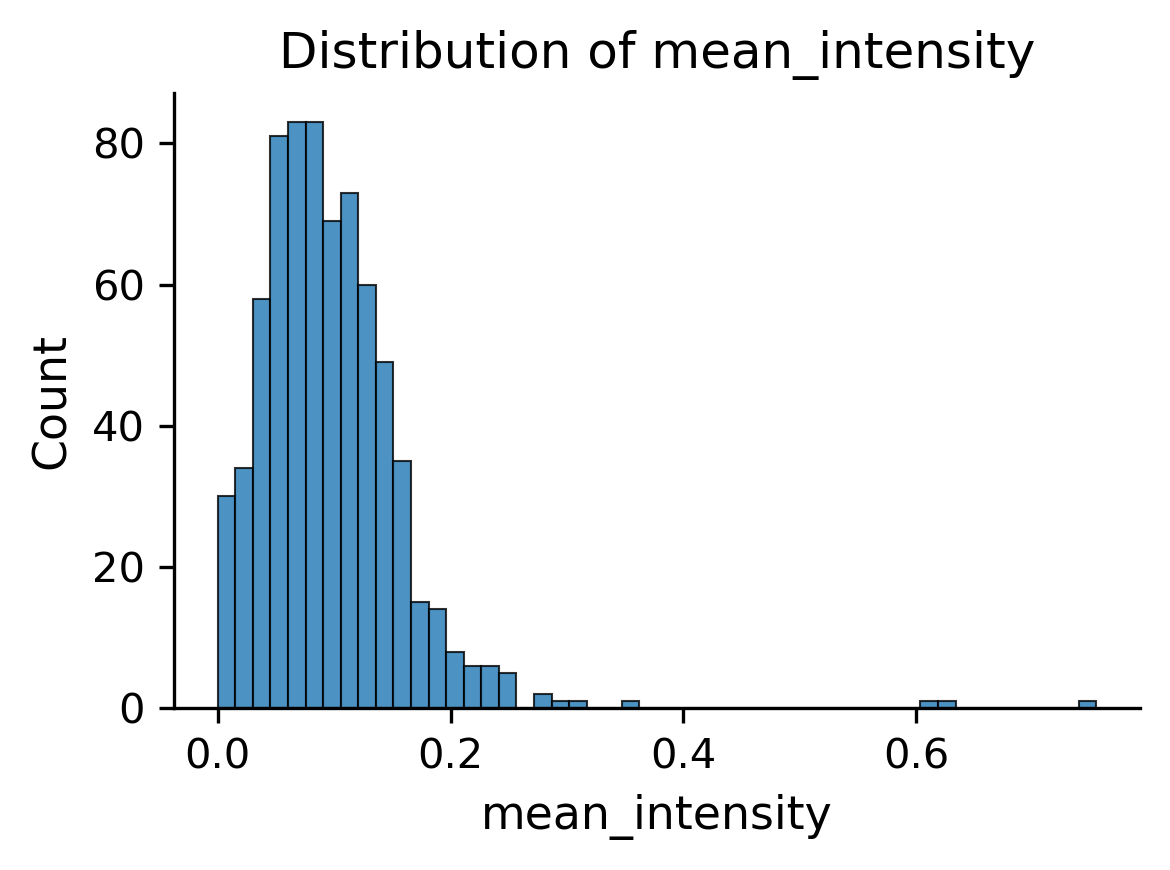

In [18]:
plot_histogram(df, "mean_intensity", bins=50, xlabel=None, title=None, figsize=(4, 3), dpi=300)

# Data import

## Filtration based on sigma value

In [ ]:
df = df[(df["sigma [nm]"] > 75)]
print("Number of foci after filtration: ", df.shape[0])


## Calculate number of outliers based on MFI of foci

In [ ]:
data = df["mean_intensity"]
mean = data.mean()
std = data.std()
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = df[df["mean_intensity"] > upper_bound]
print("Number of outliers: ", outliers.shape[0])

## Draw circle area

In [ ]:
df = pd.read_csv("./examples/run/C2_MP_U2OS_fixed_20nMJF549_ORC1_MGS1.nd2_(series_01)_0199-0257.csv")

In [ ]:
px_size_ts_x = 11.6
px_size_ts_y = 11.6

px_size_x = 57.5
px_size_y = 58.7

sx = px_size_ts_x/px_size_x
sy = px_size_ts_y/px_size_y
ssigma = np.mean([px_size_ts_x, px_size_ts_y]) / np.mean([px_size_x, px_size_y])


df["x_px"] = sx*df["x_nm"] / px_size_ts_x
df["y_px"] = sy*df["y_nm"] / px_size_ts_y

# For sigma (use average pixel size)
df["sigma_px"] = ssigma*df["sigma_nm"] / np.mean([px_size_ts_x, px_size_ts_y])

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(gray, cmap="gray")

for x_px, y_px, r_px in zip(res["x_px"], res["y_px"], res["sigma_px"]):
    # circle outline
    ax.add_patch(Circle((x_px, y_px), r_px, fill=False, edgecolor="red", linewidth=1))
    # center dot
    ax.scatter(x_px, y_px, c="red", s=6)

ax.axis("off")
plt.show()

# Kmean

In [ ]:
n_clusters = 3

# Select TWO columns
X = df[["mean_intensity", "sigma [nm]"]].dropna()

# Run KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Add cluster labels back to dataframe
df.loc[X.index, "cluster"] = labels

centers = kmeans.cluster_centers_

print("Cluster centers:")
for i, c in enumerate(centers):
    print(f"Cluster {i}: mean_intensity={c[0]:.2f}, sigma={c[1]:.2f}")

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(5, 4), dpi=200)

# Scatter plot of clusters
for cluster_id in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster_id]
    plt.scatter(cluster_data["sigma [nm]"],
                cluster_data["mean_intensity"],
                alpha=0.6,
                label=f"Cluster {cluster_id}")

# Plot cluster centers
plt.scatter(centers[:, 1],   # sigma
            centers[:, 0],   # mean_intensity
            marker="X",
            s=200,
            linewidths=2,
            edgecolors="black",
            label="Centers")

plt.xlabel("Sigma")
plt.ylabel("Mean intensity")
plt.title("KMeans Clustering (Sigma vs Intensity)")
plt.legend()

# Clean look
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
plot_histogram(df, column="sigma [nm]", xlabel="Sigma (nm)", title="Distribution of Sigma")

Task:
1. sigma - 2 populations (KMeans)
2. Outliers of sigma - check them:
 - big bright dots: analyze as a third population
 - aggregates: analyze separatly
 - MFI of nucleus - big dots/aggregates
3. How the bg susbstruction affects the sigma, MFI of foci?

In [ ]:
means = df.groupby("sigma [nm]")["mean_intensity"].mean()
plt.bar(means.index, means.values)
plt.xlabel("sigma [nm]")
plt.ylabel("Mean intensity")
plt.xticks(rotation=45)
plt.show()

# Filtration

In [ ]:
df_bright = df[df["sigma [nm]"] > 400]
df_medium = df[(df["sigma [nm]"] > 150) & (df["sigma [nm]"] <= 400)]
df_dark = df[df["sigma [nm]"] <= 150]

print("Bright foci count:", df_bright.shape[0])
print("Medium foci count:", df_medium.shape[0])
print("Dark foci count:", df_dark.shape[0])

In [ ]:
df1 = df[df["sigma [nm]"] > 500]
print("Bright foci count:", df1.shape[0])